> # **TP2: "Algoritmo de eliminación de ruido por substracción espectral"**









#### **Autores:** *Martin Nocito, Camilo Bautista, Guido Santoro*

##### **Fecha:** 20/10/2021

##### **Procesamiento Digital de Señales - UNTREF**


# Resumen

El objetivo de este trabajo es implementar un algoritmo para eliminar ruido de señales de audio siguiendo el procedimiento de substracción espectral por el método de Boll [1]. Consiste en sustraer el espectro de ruido calculado durante un período de tiempo no discursivo. Se asume que el ruido es estacionario y que una porción del inicio de la señal es un periodo de tiempo no discursivo. Luego se atenúa el ruido residual que deja la substracción realizando una rectificación de media onda y reducción de residuo del ruido. Se obtuvo que el algoritmo es útil para señales discrusivas pero ineficiente para señales musicales, dado que el ruido remanente es muy significativo.

#Desarrollo
En esta sección se detalla la implementación del algoritmo.

En primer lugar se importan las librerías a utilizar. Luego se lee el archivo de señal discrusiva utilizada para testear el algoritmo.


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import IPython.display as ipd
import scipy.signal as sig

In [27]:
voz, fs = sf.read('voz.wav')
ipd.Audio(filename='voz.wav', rate=fs)

In [28]:
def plot_sig(x, fs, title='Señal temporal'):
    t = np.linspace(0, x.size/fs, x.size)
    plt.figure(1,figsize=(16,7))
    plt.plot(t, x)
    plt.title(title)
    plt.xlabel('Tiempo[s]')
    plt.ylabel('Amplitud')
    plt.grid()
    plt.show()

El contenido discursivo está mayormente en baja frecuecia pero también hay ruido tonal. Para visualizar energía por frecuencia y tiempo se implementa la STFT:

In [29]:
def stft(x,fs,largo,paso):
    '''
    Calcula la STFT de una señal.
    
    x: array
        señal temporal
    fs: int
        frecuencia de sampleo
    largo: float
        duración de cada ventana en segundos
    paso: float
        superposicion entre ventanas en segundos
    
    X: list
        STFT de la señal. 
    '''
    N = int(largo*fs)     # Largo de ventana en muestras
    P = int(paso*fs)      # Paso en muestras
    n = np.arange(N)
    hann = 0.5 - 0.5*np.cos(2*np.pi*n/N)    # Ventana Hann
    X = []
    for i in range(0,x.size-N, P):
        y = x[i:i+N]*hann
        Y = np.fft.rfft(y)
        X.append(Y)
    return X

def plot_stft(STFT, fs, T, title='STFT'):

    '''
    Grafica la STFT.
    
    STFT: list
        Lista con la STFT a graficar
    fs: int
        Frecuencia de muestreo de la señal
    T: float
        Duración en segundos de la señal
    title: str
        Título del gráfico. Por defecto "'STFT'"
    '''

    STFT_MAG = np.asarray(np.abs(STFT))
    f = np.linspace(0, fs/2, STFT_MAG.shape[1])
    t = np.linspace(0, T, STFT_MAG.shape[0])
    plt.figure(1,figsize=(20,10))
    plt.pcolormesh(t, f, STFT_MAG.T, cmap='magma')
    plt.ylabel('Frecuencia (Hz)')
    plt.xlabel('Tiempo (s)')
    plt.title(title)
    plt.show()
    
def plot_stft2(STFT, f, t, title='STFT'):
    
    '''
    Grafica la STFT. Utilizar para STFT calculada con la función de scipy.
    
    STFT: 2Darray
        Array con la STFT a graficar
    f: array
        Eje frecuencial
    t: array
        Eje temporal
    title: str
        Título del gráfico. Por defecto 'STFT'
    '''
    plt.figure(1,figsize=(20,10))
    plt.pcolormesh(t, f, np.abs(STFT), cmap='magma')
    plt.ylabel('Frecuencia (Hz)')
    plt.xlabel('Tiempo (s)')
    plt.title(title)
    plt.show()

In [30]:
P1 = stft(voz, fs, 0.01, 0.005)
# plot_stft(P1, fs, 1)
print(np.shape(P1))

(199, 221)


Puede compararse la STFT implementada con la de scipy:

In [31]:
f, t, P1 = sig.stft(voz, fs, nperseg=int(0.01*fs))
# plot_stft2(P1, f, t)
print(P1.shape)
P1 = P1.T

(221, 201)


Hay diferencias entre la implementación y la de scipy. Por un lado, `stft` devuelve una lista, mientras que scipy devuelve un array. Además, las filas y columnas están al revés. Y por último, la cantidad de ventanas difiere. Para el resto del trabajo se utilizará la función de scipy.

Con la señal ventaneada y transformada puede procederse a realizar la supresión de ruido por substracción espectral.

El concepto fundamental de la substracción espectral es asumir que se tiene una señal $y$ que consta de la información útil discursiva $s$ y de ruido $n$ no correlacionado con la señal:
$$
y[n] = s[n] + n[n]
$$
Por la propiedad de linealidad, si se realiza la Transformada Discreta de Fourier, se tiene:
$$
Y[k] = S[k] + N[k]
$$
Por lo tanto se define un estimador de sustracción espectral de ruido $\hat{S}[k]$ como:
$$
\hat{S}[k] = (|Y[k]| - \mu[k]) e^{j\angle Y[k]}
$$
donde $\mu [k]$ es el promediado temporal del espectro de ruido.

Esto se basa en que el oido humano es poco sensible a errores o cambios de fase en períodos cortos de tiempo. Por ello la fase original puede usarse como estimador de la fase de la señal $S[k]$. 

Por lo tanto, primero debe separarse módulo y fase para cada ventana, ya que la fase de la señal procesada será la misma que la de la señal original [2]:

In [32]:
ventanas = []
fases = []
for i in range(len(P1)):
    ventanas.append(np.abs(P1[i]))
    fases.append(np.angle(P1[i]))
print('La cantidad de ventanas es',np.shape(ventanas)[0])

La cantidad de ventanas es 201


Para obtener $\mu[k]$ es necesario asumir que la señal, por un lado, tiene ruido estacionario y, además, que hay una porción de ruido al principio donde $s[n] = 0$. 
$$
\mu [k] = \frac{1}{M} \sum_{i=0}^{M-1}|Y_i[k]|
$$
donde $|Y_i[k]|$ es la i-ésima ventana donde la señal es nula y $M$ el número de ventanas en que se asume esta condición. En la señal discursiva de prueba hay aproximadamente 300 ms de ruido iniciales.

Hay 59 ventanas de ruido al inicio de la señal


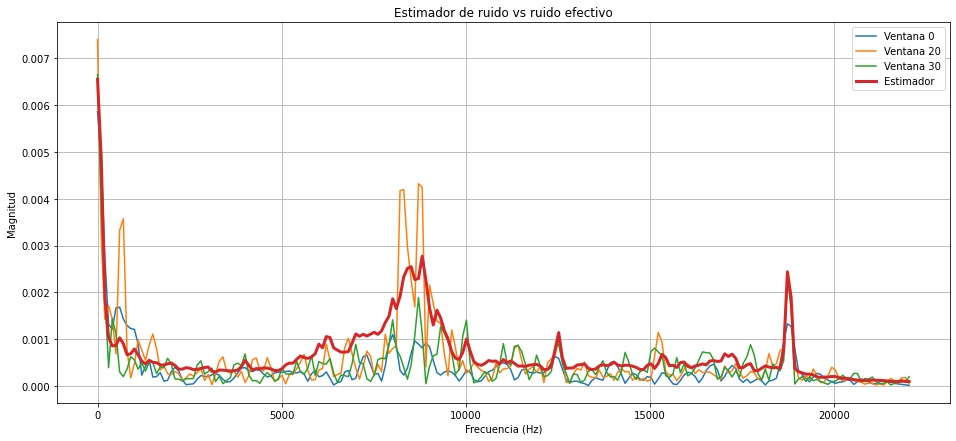

In [33]:
ruido = np.array(ventanas[0])
muestras = 0.3 * fs    # Cantidad de muestras sin señal útil
M = int(muestras/len(ventanas[0]))    # Las primeras M ventanas con ruido
print('Hay', M, 'ventanas de ruido al inicio de la señal')
for i in range(1,M):
    ruido += ventanas[i]
ruido /= M
b = 1
ruido *= b    # Sobre-sustracción

f = np.linspace(0, fs/2, ruido.size)

plt.figure(1,figsize=(16,7))
plt.plot(f, ventanas[0], label='Ventana 0')
plt.plot(f, ventanas[20], label='Ventana 20')
plt.plot(f, ventanas[30], label='Ventana 30')
plt.plot(f, ruido, label='Estimador', linewidth=3)
plt.title('Estimador de ruido vs ruido efectivo')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')
plt.legend()
plt.grid()
plt.show()

Evidentemente el estimador de ruido es similar al espectro de las primeras ventanas. También se aprecia que es un ruido que tiene contenido en baja frecuencia, entre 0 y 100 Hz, y que es tonal, con información alrededor de los 8 kHz y los 18 kHz.

En la literatura se encontró que se puede incorporar un parámetro $\beta$ que escala el estimador de ruido para realizar "sobre-sustracción" (over-substraction) de ruido. Usualmente $1<\beta<2$ [3]. 

Se procede a realizar la supresión de ruido. Se debe recorrer cada elemento de cada ventana y sustraerle el elemento correspondiente de la magnitud de ruido estimada. Este procedimiento trae aparejado un problema: puede devolver magnitudes negativas. Para solucionario es necesario realizar la rectificación de media onda.

In [34]:
for i in range(len(ventanas)):
    for k in range(len(ventanas[i])):
        if ventanas[i][k] > ruido[k]:
            ventanas[i][k] -= ruido[k]
        else: ventanas[i][k] = 0

Ahora, añadir a la salida la información de la fase original.

In [35]:
out = []
for i in range(len(ventanas)):
    out.append(ventanas[i] * np.exp(1j*fases[i]))
out = np.asarray(out)

# plot_stft(out, fs, 1, title='Señal de salida')

Por último, resta realizar la transformada inversa de tiempo corto de Fourier.

In [36]:
tiempo, voz_filt = sig.istft(out.T,fs)
np.shape(voz_filt)


(44000,)

La señal ya no tiene 44100 muestras, por lo tanto hay algún error de procedimiento.

Para simplificar, se define una función que haga todo el procedimiento.

In [37]:
def ssf(x, fs, largo=0.01, solap=None, silencio=0.3, b=1):
    
    '''
    Aplica reducción de ruido por el método de substracción espectral. Requiere que la señal no tenga información
    útil en el inicio.
    
    Parámetros:
    x: array 
        Señal a filtrar
    fs: int 
        Frecuencia de muestreo
    largo: float
        Longitud en segundos de la ventana para realizar la STFT. Por defecto largo = 0.01 seg
    solap: float
        El solapamiento en segundos entre ventana y ventana en la STFT. Por defecto es la mitad del largo. Debe ser menor
        al largo.
    silencio: float
        Tiempo en segundos al inicio de la señal donde se estimará el ruido. Se requiere que no haya información útil.
    b: int/float
        Parámetro de sobre-sustracción. Usualmente 1<b<2
    
    Salida:
    salida: array
        Señal filtrada
    tiempo: array
        Vector de tiempo de la señal
    '''
    
    if solap != None:
        solap = int(solap*fs)    # Pone el paso en muestras
    f, t, X = sig.stft(x, fs, nperseg=int(largo*fs), noverlap=solap)    # Calcula STFT
    X = X.T    # Trasponer la matriz
    
    ventanas = []
    fases = []
    for i in range(len(X)):
        ventanas.append(np.abs(X[i]))
        fases.append(np.angle(X[i]))
    
    ruido = np.array(ventanas[0])
    muestras = int(silencio * fs)    # Cantidad de muestras sin señal útil
    M = int(muestras/len(ventanas[0]))    # Las primeras M ventanas con ruido

    for i in range(1,M):
        ruido += ventanas[i]
    ruido /= M    # Estimador de ruido espectral
    
    ruido *= b    # Sobre-sustracción
    
    for i in range(len(ventanas)):
        for k in range(len(ventanas[i])):
            if ventanas[i][k] > ruido[k]:
                ventanas[i][k] -= ruido[k]
            else: ventanas[i][k] = 0    # Rectificación de media onda
    
    out = []
    for i in range(len(ventanas)):
        out.append(ventanas[i] * np.exp(1j*fases[i]))    # Agrega la magnitud y la fase
    out = np.asarray(out)
    
    tiempo, salida = sig.istft(out.T,fs, noverlap=solap)     # Antitransforma
    return salida, tiempo


Con el objeto de mejorar el filtrado de la señal, se aplica otro proceso llamado reducción de ruido residual. Consiste en disminuir las variaciones entre ventana y ventana de la magnitud de la señal $|\hat{S}[k]|$ reemplazando su valor por el mínimo de las ventanas adyacentes cuando $|\hat{S}[k]|< max\{N_R[k]\}$, siendo $max\{N_R[k]\}$ el valor máximo de ruido residual encontrado. Estos valores se obtienen seleccionando para cada valor de $k$ el máximo entre las ventanas de inactividad discursiva. En otro caso, $|\hat{S}[k]|$ no se modifica.


In [38]:
def ssf_res(x, fs, largo=0.01, solap=None, silencio=0.3, b=1):
    
    '''
    Aplica reducción de ruido por el método de substracción espectral. Requiere que la señal no tenga información
    útil en el inicio. Procesa la señal con reducción de ruido residual.
    
    Entrada:
    x: array 
        Señal a filtrar
    fs: int 
        Frecuencia de muestreo
    largo: float
        Longitud en segundos de la ventana para realizar la STFT. Por defecto largo = 0.01 seg
    solap: float
        El solapamiento en segundos entre ventana y ventana en la STFT. Por defecto es la mitad del largo. Debe ser menor
        al largo.
    silencio: float
        Tiempo en segundos al inicio de la señal donde se estimará el ruido. Se requiere que no haya información útil.
    b: int/float
        Parámetro de sobre-sustracción. Usualmente 1<b<2
    
    Salida:
    salida: array
        Señal filtrada
    tiempo: array
        Vector de tiempo de la señal
    '''
    
    if solap != None:
        solap = int(solap*fs)    # Pone el paso en muestras
    f, t, X = sig.stft(x, fs, nperseg=int(largo*fs), noverlap=solap)    # Calcula STFT
    X = X.T    # Trasponer la matriz
    
    ventanas = []
    fases = []
    for i in range(len(X)):
        ventanas.append(np.abs(X[i]))
        fases.append(np.angle(X[i]))
    
    ruido = np.array(ventanas[0])
    muestras = int(silencio * fs)    # Cantidad de muestras sin señal útil
#     nvent = np.shape(ventanas)[0]    # Número de ventanas totales
#     M = int(muestras/nvent)    # Las primeras M ventanas con ruido
    M = int(muestras/len(ventanas[0]))
    
    for i in range(1,M):
        ruido += ventanas[i]
    ruido /= M    # Estimador de ruido
    
    ruido *= b    # Oversubstract
    
    for i in range(len(ventanas)):
        for k in range(len(ventanas[i])):
            if ventanas[i][k] > ruido[k]:
                ventanas[i][k] -= ruido[k]
            else: ventanas[i][k] = 0
    
    # Reducción de ruido residual:
    
    maxres = ventanas[0]            
    for i in range(1,M):
        for k in range(len(ventanas[i])):
            if ventanas[i][k] > maxres[k]:
                maxres[k] = ventanas[i][k]    # Selecciona las magnitudes máximas en el silencio inicial luego de la substracción
    
    for i in range(1,len(ventanas)-1):
        for k in range(len(ventanas[i])):
            if ventanas[i][k] < maxres[k]:
                ventanas[i][k] = min(ventanas[i+1][k], ventanas[i][k], ventanas[i-1][k])
                # Elige el valor mínimo en ventanas adyacentes para esa frecuencia
    
    
    out = []
    for i in range(len(ventanas)):
        out.append(ventanas[i] * np.exp(1j*fases[i]))    # Agregamos la magnitud y la fase
    out = np.asarray(out)
    
    tiempo, salida = sig.istft(out.T,fs, noverlap=solap)     # Antitransformamos
    return salida, tiempo

# Resultados y Discusiones

**En la presente sección se vuelcan y analizan los resultados obtenidos en el desarrollo.**

Se observan los resultados obtenidos de la función generada para realizar reducción de ruido mediante el procedimiento de substracción espectral para el archivo de la voz. A continuación se oberva el gráfico y el audio obtenidos de la misma:

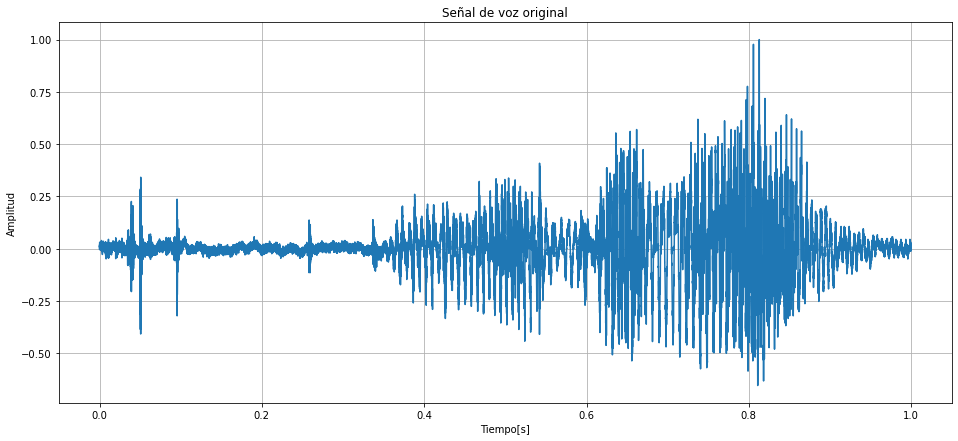

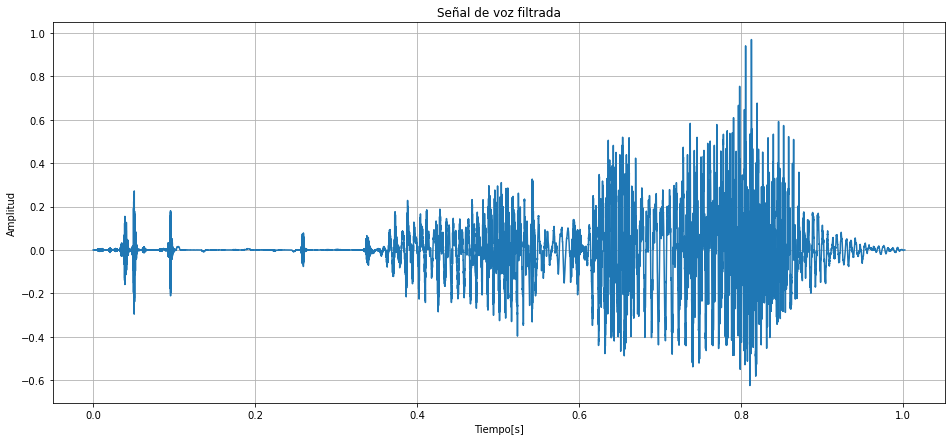

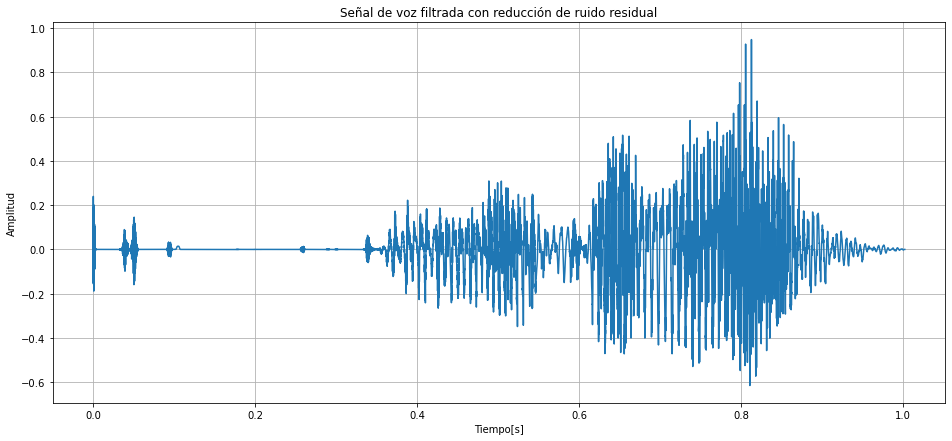

In [39]:
voz_filt, _ = ssf(voz, fs, largo=0.007, b=1.7)
sf.write('voz_filt.wav', voz_filt, fs)
voz_filtres, _ = ssf_res(voz, fs, largo=0.007, b=1.7)
sf.write('voz_filtres.wav', voz_filtres, fs)
plot_sig(voz, fs, 'Señal de voz original')
plot_sig(voz_filt,fs,'Señal de voz filtrada')
plot_sig(voz_filtres,fs,'Señal de voz filtrada con reducción de ruido residual')

In [40]:
### Señal original
ipd.Audio(voz, rate=fs)

In [41]:
### Señal filtrada
ipd.Audio(voz_filt, rate=fs)

In [42]:
### Señal filtrada con reducción de ruido residual
ipd.Audio(voz_filtres, rate=fs)

Al comparar las señales se percibe el ruido residual como tonos puros que aparecen y desaparecen rápidamente en la señal filtrada sin la reducción de ruido residual. Este efecto disminuye notablemente en la última. Se encontró que la configuración de largo de ventana de 7 ms y $\beta = 1.7$ es óptima. 

A continuación se analiza un archivo de audio de una guitarra acústica, al cual se le agregó ruido y procesó con la misma función que el archivo de voz. Luego, se calcularon las SNR del archivo con ruido y el procesado:

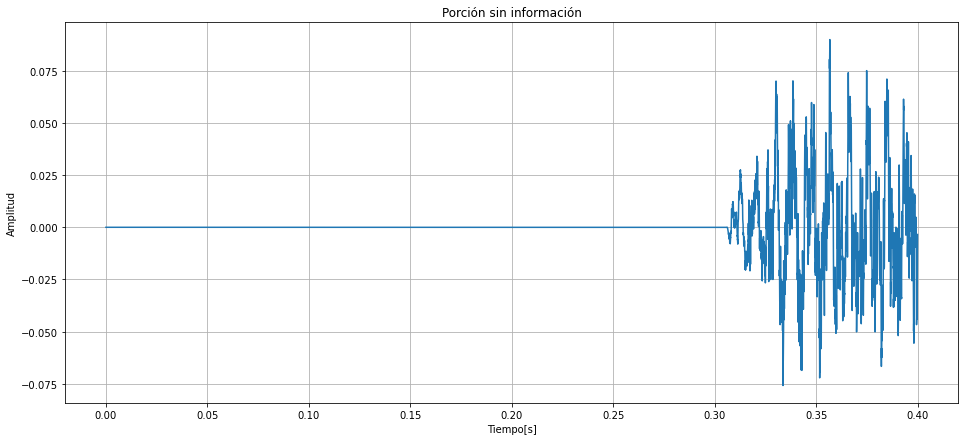

In [43]:
gtr_orig, fs = sf.read('guitarra_acustica3.wav')
plot_sig(gtr_orig[:int(0.4*fs)], fs, 'Porción sin información')

Se genera ruido aleatorio de media cero y desviación estándar 0,01. Luego se lo suma a la señal de la guitarra acústica.

In [44]:
sum_ruido = np.random.normal(0, 0.01, gtr_orig.size) # Ruido Aleatorio

gtr_al = gtr_orig + sum_ruido
sf.write('gtr_al.wav', gtr_al, fs)

# plot_sig(gtr_al, fs, 'Señal de guitarra con ruido aleatorio')

In [45]:
gtr_filt, _ = ssf(gtr_al, fs, largo=0.07, b=1.7)
sf.write('gtr_filt.wav', gtr_filt, fs)
gtr_filtres, _ = ssf_res(gtr_al, fs, largo=0.07, b=1.7)
sf.write('gtr_filtres.wav', gtr_filtres, fs)

In [46]:
sigma = np.std(gtr_al[:int(0.3*fs)])    # Calculamos la desviación estandar de ruido donde no hay actividad de señal
SNR = np.around(abs(max(gtr_al)-min(gtr_al)) / sigma, 2)
print('El SNR de la señal guitarra + ruido es', SNR)

sigma = np.std(gtr_filt[:int(0.3*fs)])
SNR_gtrfilt = np.around(abs(max(gtr_filt)-min(gtr_filt)) / sigma, 2)
print('El SNR de la señal guitarra filtrada es', SNR_gtrfilt)

sigma = np.std(gtr_filtres[:int(0.3*fs)])
SNR_gtrfiltres = np.around(abs(max(gtr_filtres)-min(gtr_filtres)) / sigma, 2)
print('El SNR de la señal guitarra filtrada con reducción de ruido residual es', SNR_gtrfiltres)


El SNR de la señal guitarra + ruido es 35.08
El SNR de la señal guitarra filtrada es 293.16
El SNR de la señal guitarra filtrada con reducción de ruido residual es 252.55


In [47]:
ipd.Audio(gtr_al, rate=fs)

In [48]:
ipd.Audio(gtr_filt, rate=fs)

In [49]:
ipd.Audio(gtr_filtres, rate=fs)

Se puede ver que la SNR de la señal filtrada mejora respecto a la señal con ruido y más aún con post procesamiento. Sin embargo, al escuchar el archivo, se puede notar que el ruido de la señal disminuye notablemente pero aparece el ruido residual efecto del filtrado. Este ruido es muy notorio en la señal, y el algoritmo de reducción de ruido residual no introduce una mejora significativa.

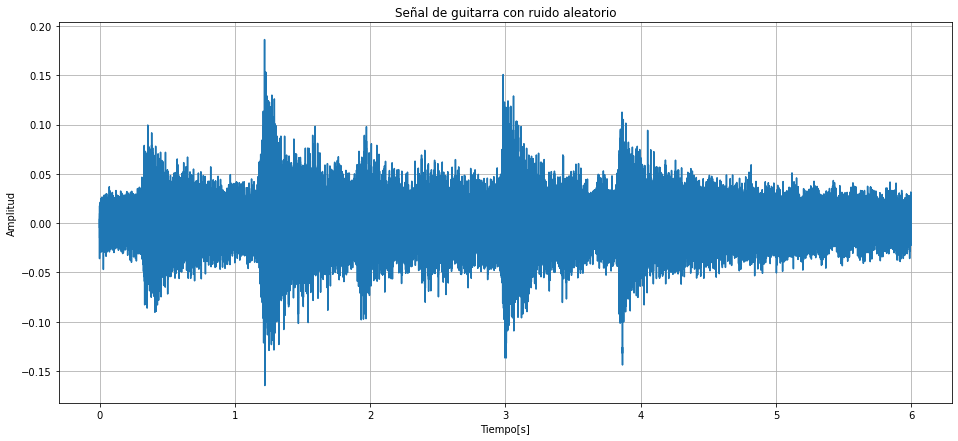

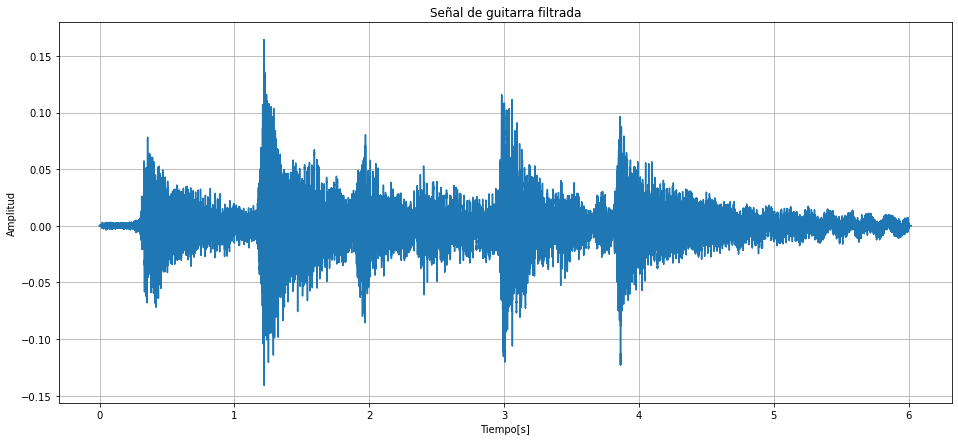

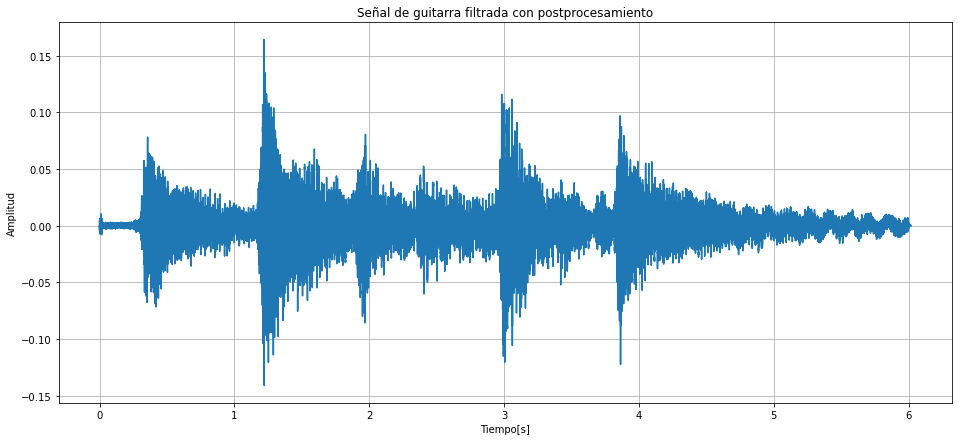

In [50]:
plot_sig(gtr_al, fs, 'Señal de guitarra con ruido aleatorio')
plot_sig(gtr_filt, fs, 'Señal de guitarra filtrada')
plot_sig(gtr_filtres, fs, 'Señal de guitarra filtrada con postprocesamiento')

Gráficamente puede verse la mejora en la SNR y la inefectividad de la reducción de ruido residual.

Por un lado, para la señal discursiva, se encontró que un largo de ventana de aproximadamente 7 ms  da buenos resultados. Esto se debe a que una señal de este tipo la información es de muy corta duración, por lo tanto en la relación de compromiso entre localización temporal y resolución espectral tiende a tener más peso la localización temporal. Esto también se justifica dado que la información de una señal discursiva tiene más información en bajas frecuencias. Luego, al realizar la reducción de ruido se observó que la sobre-sustracción tiene un efecto de mejora hasta un cierto límite a partir del cual la señal se distorsiona. Lo mismo ocurre si se reduce más el largo de la ventana. Al realizar la reducción de ruido residual, el resultado mejora y se perciben en menor medida los tonos fluctuantes en el tiempo.

Por otro lado, para la señal de guitarra acústica, el resultado fue distinto. Un largo de ventana óptimo es mayor a los  50 ms, lo cual responde a la naturaleza del instrumento, dado que la información fluctúa más lentamente en el tiempo. Se observó que el efecto de la reducción de ruido por sustracción espectral depende fuertemente de la SNR de la entrada, ya que con valores de  ruido aditivo con $\sigma > 0.01$ el algoritmo no es de utilidad. Esto puede deberse al tipo de ruido utilizado para testear el algoritmo. En la literatura [3] se encontró que el tipo de ruido debe ser ruido ergódico estacionario en sentido amplio (*WSS ergodic process*). Existe la posibilidad de que el ruido utilizado no cumpla esta condición, pero no se encontraron conclusiones determinantes al respecto. 


# Conclusiones

Tanto la sustracción espectral como la reducción del ruido residual causan una mejora en la SNR de la señal. En las gráficas la “limpieza” del ruido es notoria. Ahora bien, a la hora de analizar los archivos mediante la escucha puede percibirse que el arhivo de voz obtiene mejores resultados que la señal musical. Para el primero, el ruido residual disminuye considerablemente y el ruido de la señal tambien. Para el caso del archivo del instrumento, si bien se logra disminuir el ruido de la señal, su comportamiento con la reducción del ruido residual difiere respecto al de la voz. El ruido se mantiene presente y se nota una disminución de claridad en altas frecuencias, además de la presencia de ruido residual. Esta diferencia puede deberse a que el instrumento comprende señales de variacion mas lenta que la voz, causando así difucltades en el algoritmo para la distinción de ruido residual.

Para finalizar, puede afirmarse que el algoritmo funciona para señales discursivas bajo condiciones muy específicas. Dentro de sus limitaciones, se encuentran que el ruido estimado no se actualiza dado que utiliza el principio de la señal para estimar el espectro de ruido, otra condición requerida. Esto vuelve necesario que el ruido sea estacionario, dado que si se generan fluctuaciones, no se verán afectadas. Por otro lado, este procedimiento genera distorsión de magnitud y fase en la señal y deben aplicarse métodos como la reducción de ruido residual y la rectificación de media onda para disminuir su efecto. También depende estrechamente de la relación señal a ruido de la señal a filtrar. 

# Referencias

1 Steven Boll - Suppression of Acoustic Noise in Speech Using Spectral Subtraction- IEEE TRANSACTIONS ON ACOUSTICS, SPEECH, AND SIGNAL PROCESSING, VOL. ASSP-27, NO. 2, APRIL 1979.

2 Navneet Upadhyay & Abhijit Karmakar - Speech Enhancement using Spectral Subtraction-type Algorithms: A Comparison and Simulation Study - ELEVENTH INTERNATIONAL MULTI-CONFERENCE ON INFORMATION PROCESSING-2015 (IMCIP-2015)

3 Saeed V. Vaseghi - Advanced Digital Signal Processing and Noise Reduction, Second Edition (Chapter 11) - Year 2000. 

4 Dr Gilbert Soulodre - Digital Signal Processing in the Frequency Domain - JUNE 2018.

5 Shyam Prajapati – Spectral-Substraction (https://github.com/shyamprajapati789/Spectral-Subtraction/blob/master/SpectralSubtraction.py) - JULY, 2018